# Evaluation Results

In this notebook, I will analyze the results obtained in the evaluation form for each of the groups.
This file contains the relevant graphs and information that can be infered from the participant's answers.

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from scipy.stats import shapiro, ttest_ind, mannwhitneyu
import plot_likert as pl

plantumlAnswersPath = "../data/control/plantUML_answers.csv"
visualAnswersPath = "../data/experimental/visual_answers_eng.csv"

First, we define the functions for the statistical difference tests.

In [67]:
def testShapiroWilk(g1QuestionAnswers, g2QuestionAnswers, alpha = 0.05, debug = False):
    g1Normal = False
    g2Normal = False

    _, pG1 = shapiro(g1QuestionAnswers)
    _, pG2 = shapiro(g2QuestionAnswers)

    g1Normal = pG1 > alpha
    g2Normal = pG2 > alpha

    if (debug): 
        print(f"(ShapiroWilk) G1 Normal? {"Yes" if g1Normal else "No"} - G2 Normal? {"Yes" if g2Normal else "No"}") 
        
    return g1Normal, g2Normal

def testMannWhitneyU(g1QuestionAnswers, g2QuestionAnswers, alpha = 0.05, alt="two-sided", debug = False):
    stat, p_value = mannwhitneyu(g1QuestionAnswers, g2QuestionAnswers, alternative=alt)
    if (debug): print("(MWu) Statistics=%.2f, p=%.2f" % (stat, p_value))

    return stat, p_value

def testTTest(g1QuestionAnswers, g2QuestionAnswers, alpha = 0.05, alt="two-sided", debug = False):
    # alt can be "two-sided", "greater" or "less"
    stat, p_value = ttest_ind(g1QuestionAnswers, g2QuestionAnswers, alternative=alt)
    if (debug): print("(t_test) Statistics=%.2f, p=%.2f" % (stat, p_value))

    return stat, p_value

def testStatisticalDifference(g1QuestionAnswers, g2QuestionAnswers, alpha = 0.05, alt="two-sided", debug = False):
    g1Normal, g2Normal = testShapiroWilk(g1QuestionAnswers, g2QuestionAnswers, alpha, debug)

    message = ""

    if (alt == "less"):
        message = "Significantly less? "
    elif (alt == "greater"):
        message = "Significantly greater? "
    else:
        message = "Significant statiscal difference? "

    result = ""

    try:
        if (g1QuestionAnswers == g2QuestionAnswers):
            return "No difference between groups"
    except ValueError as e:
        equal = True
        for idx in range(len(g1QuestionAnswers)):
            if (g1QuestionAnswers[idx] != g2QuestionAnswers[idx]):
                equal = False
                break
        
        if (equal):
            return "No difference between groups"


    if (g1Normal and g2Normal):
        # If both normal do t_test
        if (debug): print(f"Both groups follow normal distribution")

        _, result = testTTest(g1QuestionAnswers, g2QuestionAnswers, alpha, alt, debug)

        if (alt == "less" or alt == "greater"):
            message += "Yes" if result else "No"
        else:
            message += "No" if result else "Yes"
        

        if (debug): print(f"(t_test) {message}")
    else:
        # Else do Mann-Whitney U test
        if (debug): print(f"At least one of the groups doesn't follow normal distribution")

        _, result = testMannWhitneyU(g1QuestionAnswers, g2QuestionAnswers, alpha, alt, debug)

        if (alt == "less" or alt == "greater"):
            message += "Yes" if result else "No"
        else:
            message += "No" if result else "Yes"

        if (debug): print(f"(MWu) {message}")

    return result

Below I'm loading the *.csv* files and removing the timestamp columns from each of them.

In [68]:
plantumlAnswers = pd.read_csv(plantumlAnswersPath)
plantumlAnswers.drop('Carimbo de data/hora', axis=1, inplace=True)

visualAnswers = pd.read_csv(visualAnswersPath)
visualAnswers.drop('Carimbo de data/hora', axis=1, inplace=True)

Now I'll rename the columns to smaller descriptive names. Sort the lines by id and define the row id as the id provided in the experience.

In [69]:
plantumlAnswers.rename(columns = {'Please insert your assigned ID.':'id', 
                                  'Start of Task 1': 'start_t1',
                                  'Task 1': 't1',
                                  'Start of Task 2': 'start_t2',
                                  'Task 2': 't2',
                                  'Start of Task 3': 'start_t3',
                                  'Task 3': 't3',
                                  'Start of Task 4': 'start_t4',
                                  'Start of Task 5': 'start_t5',
                                  'Start of Task 6': 'start_t6',
                                  'End of the experimental tasks': 'end_all_tasks',
                                  'Perceived Usefulness [Using this tool in my job would enable me to accomplish tasks more quickly.]': 'tam_pu_1',
                                  'Perceived Usefulness [Using this tool would improve my job performance.]': 'tam_pu_2',
                                  'Perceived Usefulness [Using this tool in my job would increase my productivity.]': 'tam_pu_3',
                                  'Perceived Usefulness [Using this tool would enhance the effectiveness on the job.]': 'tam_pu_4',
                                  'Perceived Usefulness [Using this tool would make it easier to do my job.]': 'tam_pu_5',
                                  'Perceived Usefulness [I would find this tool useful in my job.]': 'tam_pu_6',
                                  'Please justify your answers regarding the usefulness of the tool.': 'tam_pu_just',
                                  'Perceived Ease-of-use [Learning to operate this tool would be easy for me.]': 'tam_peu_1',
                                  'Perceived Ease-of-use [I would find it easy to get this tool to do what I want it to do.]': 'tam_peu_2',
                                  'Perceived Ease-of-use [My interaction with this tool would be clear and understandable.]': 'tam_peu_3',
                                  'Perceived Ease-of-use [I would find this tool would be clear and understandable.]': 'tam_peu_4',
                                  'Perceived Ease-of-use [It would be easy for me to become skillful at using this tool.]': 'tam_peu_5',
                                  'Perceived Ease-of-use [I would find this tool easy to use.]': 'tam_peu_6',
                                  'Please justify your answers regarding the ease-of-use of the tool.': 'tam_peu_just',
                                  'System Usability Score (SUS) [I think that I would like to use this system frequently.]': 'sus_1',
                                  'System Usability Score (SUS) [I found the system unnecessarily complex.]': 'sus_2',
                                  'System Usability Score (SUS) [I thought the system was easy to use.]': 'sus_3',
                                  'System Usability Score (SUS) [I think that I would need the support of a technical person to be able to use this system.]': 'sus_4',
                                  'System Usability Score (SUS) [I found the various functions in this system were well integrated.]': 'sus_5',
                                  'System Usability Score (SUS) [I thought there was too much inconsistency in this system.]': 'sus_6',
                                  'System Usability Score (SUS) [I would imagine that most people would learn to use this system very quickly.]': 'sus_7',
                                  'System Usability Score (SUS) [I found the system very cumbersome to use.]': 'sus_8',
                                  'System Usability Score (SUS) [I felt very confident using the system.]': 'sus_9',
                                  'System Usability Score (SUS) [I needed to learn a lot of things before I could get going with this system.]': 'sus_10',
                                  'Please justify your answers regarding the usability of the tool.': 'sus_just',
                                  'Do you consider having a feature “undo/redo actions” important for this type of tool?': 'undo_redo',
                                  'Why?': 'undo_redo_just',
                                  'Do you consider having a feature “move elements” important for this type of tool?': 'move_elements',
                                  'Why?.1': 'move_elements_just',
                                  'Do you consider having a feature “use of keyboard keys” important for this type of tool?': 'keyboard_keys',
                                  'Why?.2': 'keyboard_keys_just',
                                  'Do you believe the diagram achieved is compliant with UML standards?': 'uml_compliant',
                                  'Why?.3': 'uml_compliant_just',
                                  'Do you have any comments or suggestions, or would like to suggest any new features?': 'comments',
                                  }, inplace = True)

plantumlAnswers.sort_values(by='id', inplace=True)
plantumlAnswers.set_index('id', inplace=True)
plantumlAnswers.columns

Index(['start_t1', 't1', 'start_t2', 't2', 'start_t3', 't3', 'start_t4',
       'start_t5', 'start_t6', 'end_all_tasks', 'tam_pu_1', 'tam_pu_2',
       'tam_pu_3', 'tam_pu_4', 'tam_pu_5', 'tam_pu_6', 'tam_pu_just',
       'tam_peu_1', 'tam_peu_2', 'tam_peu_3', 'tam_peu_4', 'tam_peu_5',
       'tam_peu_6', 'tam_peu_just', 'sus_1', 'sus_2', 'sus_3', 'sus_4',
       'sus_5', 'sus_6', 'sus_7', 'sus_8', 'sus_9', 'sus_10', 'sus_just',
       'undo_redo', 'undo_redo_just', 'move_elements', 'move_elements_just',
       'keyboard_keys', 'keyboard_keys_just', 'uml_compliant',
       'uml_compliant_just', 'comments'],
      dtype='object')

In [70]:
visualAnswers.rename(columns = {'Please insert your assigned ID.':'id', 
                                  'Start of Task 1': 'start_t1',
                                  'Task 1': 't1',
                                  'Start of Task 2': 'start_t2',
                                  'Task 2': 't2',
                                  'Start of Task 3': 'start_t3',
                                  'Task 3': 't3',
                                  'Start of Task 4': 'start_t4',
                                  'Start of Task 5': 'start_t5',
                                  'Start of Task 6': 'start_t6',
                                  'End of the experimental tasks': 'end_all_tasks',
                                  'Perceived Usefulness [Using this tool in my job would enable me to accomplish tasks more quickly.]': 'tam_pu_1',
                                  'Perceived Usefulness [Using this tool would improve my job performance.]': 'tam_pu_2',
                                  'Perceived Usefulness [Using this tool in my job would increase my productivity.]': 'tam_pu_3',
                                  'Perceived Usefulness [Using this tool would enhance the effectiveness on the job.]': 'tam_pu_4',
                                  'Perceived Usefulness [Using this tool would make it easier to do my job.]': 'tam_pu_5',
                                  'Perceived Usefulness [I would find this tool useful in my job.]': 'tam_pu_6',
                                  'Please justify your answers regarding the usefulness of the tool.': 'tam_pu_just',
                                  'Perceived Ease-of-use [Learning to operate this tool would be easy for me.]': 'tam_peu_1',
                                  'Perceived Ease-of-use [I would find it easy to get this tool to do what I want it to do.]': 'tam_peu_2',
                                  'Perceived Ease-of-use [My interaction with this tool would be clear and understandable.]': 'tam_peu_3',
                                  'Perceived Ease-of-use [I would find this tool would be clear and understandable.]': 'tam_peu_4',
                                  'Perceived Ease-of-use [It would be easy for me to become skillful at using this tool.]': 'tam_peu_5',
                                  'Perceived Ease-of-use [I would find this tool easy to use.]': 'tam_peu_6',
                                  'Please justify your answers regarding the ease-of-use of the tool.': 'tam_peu_just',
                                  'System Usability Score (SUS) [I think that I would like to use this system frequently.]': 'sus_1',
                                  'System Usability Score (SUS) [I found the system unnecessarily complex.]': 'sus_2',
                                  'System Usability Score (SUS) [I thought the system was easy to use.]': 'sus_3',
                                  'System Usability Score (SUS) [I think that I would need the support of a technical person to be able to use this system.]': 'sus_4',
                                  'System Usability Score (SUS) [I found the various functions in this system were well integrated.]': 'sus_5',
                                  'System Usability Score (SUS) [I thought there was too much inconsistency in this system.]': 'sus_6',
                                  'System Usability Score (SUS) [I would imagine that most people would learn to use this system very quickly.]': 'sus_7',
                                  'System Usability Score (SUS) [I found the system very cumbersome to use.]': 'sus_8',
                                  'System Usability Score (SUS) [I felt very confident using the system.]': 'sus_9',
                                  'System Usability Score (SUS) [I needed to learn a lot of things before I could get going with this system.]': 'sus_10',
                                  'Please justify your answers regarding the usability of the tool.': 'sus_just',
                                  'Do you consider having a feature “undo/redo actions” important for this type of tool?': 'undo_redo',
                                  'Why?': 'undo_redo_just',
                                  'Do you consider having a feature “move elements” important for this type of tool?': 'move_elements',
                                  'Why?.1': 'move_elements_just',
                                  'Do you consider having a feature “use of keyboard keys” important for this type of tool?': 'keyboard_keys',
                                  'Why?.2': 'keyboard_keys_just',
                                  'Do you believe the diagram achieved is compliant with UML standards?': 'uml_compliant',
                                  'Why?.3': 'uml_compliant_just',
                                  'Do you have any comments or suggestions, or would like to suggest any new features?': 'comments',
                                  }, inplace = True)

visualAnswers.sort_values(by='id', inplace=True)
visualAnswers.set_index('id', inplace=True)
visualAnswers.columns

Index(['start_t1', 't1', 'start_t2', 't2', 'start_t3', 't3', 'start_t4',
       'start_t5', 'start_t6', 'end_all_tasks', 'tam_pu_1', 'tam_pu_2',
       'tam_pu_3', 'tam_pu_4', 'tam_pu_5', 'tam_pu_6', 'tam_pu_just',
       'tam_peu_1', 'tam_peu_2', 'tam_peu_3', 'tam_peu_4', 'tam_peu_5',
       'tam_peu_6', 'tam_peu_just', 'sus_1', 'sus_2', 'sus_3', 'sus_4',
       'sus_5', 'sus_6', 'sus_7', 'sus_8', 'sus_9', 'sus_10', 'sus_just',
       'undo_redo', 'undo_redo_just', 'move_elements', 'move_elements_just',
       'keyboard_keys', 'keyboard_keys_just', 'uml_compliant',
       'uml_compliant_just', 'comments'],
      dtype='object')

Now I will separate the comments from the 'quantitative' answers. And create separate datasets for each set of questions.

In [71]:
plantumlTasks = plantumlAnswers[['start_t1', 't1', 'start_t2', 't2', 'start_t3', 't3', 'start_t4', 'start_t5', 'start_t6', 'end_all_tasks']].copy()
plantumlTam = plantumlAnswers[['tam_pu_1', 'tam_pu_2', 'tam_pu_3', 'tam_pu_4', 'tam_pu_5', 'tam_pu_6', 'tam_pu_just', 'tam_peu_1', 'tam_peu_2', 'tam_peu_3', 'tam_peu_4', 'tam_peu_5', 'tam_peu_6', 'tam_peu_just']].copy()
plantumlSus = plantumlAnswers[['sus_1', 'sus_2', 'sus_3', 'sus_4', 'sus_5', 'sus_6', 'sus_7', 'sus_8', 'sus_9', 'sus_10', 'sus_just']].copy()
plantumlFeatures = plantumlAnswers[['undo_redo', 'undo_redo_just', 'move_elements', 'move_elements_just', 'keyboard_keys', 'keyboard_keys_just', 'uml_compliant', 'uml_compliant_just', 'comments']].copy()


visualTasks = visualAnswers[['start_t1', 't1', 'start_t2', 't2', 'start_t3', 't3', 'start_t4', 'start_t5', 'start_t6', 'end_all_tasks']].copy()
visualTam = visualAnswers[['tam_pu_1', 'tam_pu_2', 'tam_pu_3', 'tam_pu_4', 'tam_pu_5', 'tam_pu_6', 'tam_pu_just', 'tam_peu_1', 'tam_peu_2', 'tam_peu_3', 'tam_peu_4', 'tam_peu_5', 'tam_peu_6', 'tam_peu_just']].copy()
visualSus = visualAnswers[['sus_1', 'sus_2', 'sus_3', 'sus_4', 'sus_5', 'sus_6', 'sus_7', 'sus_8', 'sus_9', 'sus_10', 'sus_just']].copy()
visualFeatures = visualAnswers[['undo_redo', 'undo_redo_just', 'move_elements', 'move_elements_just', 'keyboard_keys', 'keyboard_keys_just', 'uml_compliant', 'uml_compliant_just', 'comments']].copy()

In [72]:
plantumlTasks

,start_t1,t1,start_t2,t2,start_t3,t3,start_t4,start_t5,start_t6,end_all_tasks
id,,,,,,,,,,
SB1,15:23,3,15:25,5,15:27,2,15:28,15:31,15:32,15:33
SB2,15:23,3,15:25,5,15:26,2,15:29,15:30,15:32,15:35
SB3,15:22,3,15:24,5,15:26,2,15:27,15:29,15:30,15:31
SB4,15:23,4,15:24,5,15:25,2,15:26,15:26,15:27,15:28
SB5,15:24,3,15:25,5,15:27,2,15:27,15:30,15:31,15:32
SB6,15:24,4,15:25,5,15:26,2,15:28,15:30,15:31,15:32


In [73]:
plantumlTam

,tam_pu_1,tam_pu_2,tam_pu_3,tam_pu_4,tam_pu_5,tam_pu_6,tam_pu_just,tam_peu_1,tam_peu_2,tam_peu_3,tam_peu_4,tam_peu_5,tam_peu_6,tam_peu_just
id,,,,,,,,,,,,,,
SB1,Slightly Agree,Neither,Neither,Neither,Quite Agree,Quite Agree,"In many of the options I selected ""Neither"", b...",Strongly Agree,Strongly Agree,Strongly Agree,Quite Agree,Strongly Agree,Quite Agree,"Overall, it is very simple and straightforward..."
SB2,Quite Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,It is easy to use and simpler to work with tha...,Quite Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,It is easy to understand what types of boxes a...
SB3,Slightly Agree,Quite Agree,Quite Agree,Slightly Agree,Quite Agree,Strongly Agree,The tool allows to quickly create a uml diagra...,Strongly Agree,Slightly Agree,Quite Agree,Quite Agree,Quite Agree,Quite Agree,"It is easy to edit and to add components , the..."
SB4,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Having a tool that automates the process of do...,Slightly Agree,Quite Agree,Slightly Agree,Strongly Agree,Strongly Agree,Quite Agree,Given that the underline language technology c...
SB5,Quite Agree,Strongly Agree,Quite Agree,Slightly Agree,Quite Agree,Strongly Agree,The tool can improve the worker's performance ...,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Quite Agree,Strongly Agree,The interface of the tool is clean and gives g...
SB6,Strongly Agree,Quite Agree,Quite Agree,Slightly Agree,Quite Agree,Strongly Agree,For the job of creating and maintaining archit...,Strongly Agree,Quite Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,The tool is very intuitive and simple to use. ...


In [74]:
plantumlSus

,sus_1,sus_2,sus_3,sus_4,sus_5,sus_6,sus_7,sus_8,sus_9,sus_10,sus_just
id,,,,,,,,,,,
SB1,Neither,Disagree,Strongly Agree,Strongly Disagree,Strongly Agree,Strongly Disagree,Strongly Agree,Neither,Disagree,Strongly Disagree,The usability is very good for a starting poin...
SB2,Strongly Agree,Strongly Disagree,Strongly Agree,Strongly Disagree,Strongly Agree,Strongly Disagree,Strongly Agree,Strongly Disagree,Strongly Agree,Strongly Disagree,"I think anyone, regardless of having the speci..."
SB3,Agree,Disagree,Agree,Neither,Agree,Disagree,Agree,Disagree,Strongly Agree,Neither,I found it quite intuitive to add/edit/delete ...
SB4,Agree,Disagree,Strongly Agree,Agree,Agree,Strongly Disagree,Strongly Agree,Strongly Disagree,Strongly Agree,Disagree,"The tool was very usable, the hash IDs could b..."
SB5,Agree,Disagree,Strongly Agree,Disagree,Agree,Strongly Disagree,Agree,Strongly Disagree,Agree,Disagree,The system is easy to understand after a quick...
SB6,Neither,Strongly Disagree,Strongly Agree,Strongly Disagree,Strongly Agree,Strongly Disagree,Agree,Strongly Disagree,Agree,Strongly Disagree,The system is very straight-forward and doesn'...


In [75]:
plantumlFeatures

,undo_redo,undo_redo_just,move_elements,move_elements_just,keyboard_keys,keyboard_keys_just,uml_compliant,uml_compliant_just,comments
id,,,,,,,,,
SB1,Yes,It is very important to don't lose time trying...,Yes,This tool reminds me of draw.io and I would en...,No,I don't see people using the keyboard that muc...,Yes,"Although I am not sure, it seems that it follo...",I would like to see this extended to other typ...
SB2,Yes,Many times you delete or change things that yo...,Yes,moving elements that may be related together i...,Yes,"As with every digital tool, the use of keyboar...",Yes,I am not sure of what are the correct UML stan...,No
SB3,Yes,It is easier to reset to previous state,Yes,It helps if I want to change positions in the ...,No,NaN,Yes,NaN,NaN
SB4,Yes,"A delete action that wasn't planned, or one th...",Yes,For people with ADHD that's a really important...,Yes,"For a tool whose purpose is efficiency, to max...",Yes,"It's written in a ""well documented"" language (...",The hash IDs could be occluded in the frontend...
SB5,Yes,"As in many scenarios, you can perform an actio...",Yes,It allows people to organize the elements a li...,Yes,I think the system works best with pointer con...,Yes,"It seems that way, but I would need to review ...",A feature that I think could be interesting is...
SB6,Yes,Although you can always revert it to the origi...,No,Since the elements are automatically rendered ...,No,Although it could be useful for short-cutting ...,Yes,Since it's being generated automatically with ...,It would be nice to be able to click on a prop...


In [76]:
visualTasks

,start_t1,t1,start_t2,t2,start_t3,t3,start_t4,start_t5,start_t6,end_all_tasks
id,,,,,,,,,,
WM1,16:38,4,16:40,5,16:42,2,16:43,16:48,16:49,16:50
WM2,16:37,4,16:38,5,16:39,2,16:40,16:42,16:42,16:43
WM3,16:38,4,16:39,5,16:41,2,16:42,16:43,16:44,16:45
WM4,16:38,4,16:39,5,16:40,2,16:41,16:43,16:44,16:45
WM5,16:39,4,16:39,5,16:40,2,16:41,16:45,16:45,16:46
WM6,16:40,4,16:41,5,16:42,2,16:43,16:46,16:47,16:49


In [77]:
visualTam

,tam_pu_1,tam_pu_2,tam_pu_3,tam_pu_4,tam_pu_5,tam_pu_6,tam_pu_just,tam_peu_1,tam_peu_2,tam_peu_3,tam_peu_4,tam_peu_5,tam_peu_6,tam_peu_just
id,,,,,,,,,,,,,,
WM1,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,The tool allow us to quickly set up something ...,Quite Agree,Quite Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Pretty intuitive but missing ctrl c/ctrl v. Al...
WM2,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,\nI'm used to using tools like LucidChart and ...,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,I was able to do all the tasks from this exper...
WM3,Quite Disagree,Quite Disagree,Quite Disagree,Quite Disagree,Quite Disagree,Quite Disagree,I don't use docker nor diagrams in my job,Quite Agree,Strongly Agree,Strongly Agree,Slightly Agree,Strongly Agree,Quite Agree,"it's just an overall easy to use tool, it coul..."
WM4,Quite Agree,Neither,Quite Agree,Quite Agree,Quite Agree,Quite Agree,I think the tool can be very useful to properl...,Strongly Agree,Quite Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,I got a brief explanation before starting this...
WM5,Slightly Agree,Slightly Agree,Slightly Agree,Slightly Agree,Quite Agree,Slightly Agree,The tool would be good to rapidly draft the ar...,Strongly Agree,Quite Agree,Quite Agree,Neither,Slightly Agree,Slightly Disagree,The tool is simple. That allows for a user to ...
WM6,Slightly Agree,Slightly Disagree,Quite Agree,Neither,Slightly Agree,Slightly Agree,The tool is useful in the sense that it avoids...,Strongly Agree,Quite Agree,Quite Agree,Quite Agree,Quite Agree,Strongly Agree,The way to manipulate the elements is simple a...


In [78]:
visualSus

,sus_1,sus_2,sus_3,sus_4,sus_5,sus_6,sus_7,sus_8,sus_9,sus_10,sus_just
id,,,,,,,,,,,
WM1,Strongly Agree,Disagree,Strongly Agree,Strongly Disagree,Strongly Agree,Strongly Disagree,Strongly Agree,Disagree,Strongly Agree,Strongly Disagree,Easy to learn and discover stuff by myself
WM2,Agree,Strongly Disagree,Strongly Agree,Strongly Disagree,Strongly Agree,Strongly Disagree,Strongly Agree,Strongly Disagree,Agree,Strongly Disagree,The tool is very easy to use and I believe tha...
WM3,Disagree,Disagree,Agree,Disagree,Agree,Strongly Disagree,Neither,Strongly Disagree,Strongly Agree,Disagree,I believe some people will have issues with th...
WM4,Agree,Disagree,Agree,Strongly Disagree,Agree,Strongly Disagree,Strongly Agree,Strongly Disagree,Agree,Strongly Disagree,It's hard to justify - but I felt like control...
WM5,Neither,Agree,Agree,Strongly Disagree,Agree,Disagree,Strongly Agree,Strongly Disagree,Agree,Strongly Disagree,The system is simple and quite straight forwar...
WM6,Agree,Neither,Agree,Disagree,Agree,Strongly Disagree,Agree,Disagree,Neither,Disagree,The tool is quite intuitive and not overwhelmi...


In [79]:
visualFeatures

,undo_redo,undo_redo_just,move_elements,move_elements_just,keyboard_keys,keyboard_keys_just,uml_compliant,uml_compliant_just,comments
id,,,,,,,,,
WM1,Yes,"As it is so common, it's comfortable to have. ...",Yes,Pretty useful when refactoring architecture,Yes,Better for small adjustments,Yes,Well readjusting even when trying to move bold...,Copy and past would be very helpful
WM2,Yes,I didn't have the misfortune of making a mista...,Yes,This feature is important both for design purp...,Yes,"I don't use keyboard that much, I prefer to us...",Yes,It has all necessary components available and ...,Just for design purposes might be nice in the ...
WM3,Yes,"People make mistakes, if you delete an element...",Yes,It would help better visualizing the actual ar...,Yes,Some keyboard key interactions would be very h...,Yes,"I'm not 100% on the UML standards of others, b...","More customization, this tool is going to be u..."
WM4,Yes,It's really just a usability feature! Even if ...,Yes,"Yes. I, for one, messed around with the positi...",Yes,"Intuitiveness. It's almost expected - ""delete""...",Yes,"In my opinion, it simply is. I could clearly u...",Suggestions:\n- Undo feature (with button + ke...
WM5,Yes,"""Oh no! I hit delete. My 20-properties compone...",Yes,"For more complex architectures, the user might...",Yes,"While not absolutely necessary, it increases u...",No,No. I found lacking support for some of the fu...,Maybe consider a fullscreen mode where the dia...
WM6,Yes,Because one of the most frequent things that h...,Yes,To readjust the layout automatically generated...,No,NaN,Yes,NaN,Suggestions:\n- add a link should add it right...


## Analysis on tasks

First I'll figure out if the participants answered correctly to the tasks and how long it took them to execute each of the tasks and the total time for all tasks.

In [80]:
t1Durations = []
t2Durations = []
t3Durations = []
t4Durations = []
t5Durations = []
t6Durations = []
totalTimes = []

for idx in plantumlTasks.index:
    startTime = dt.strptime(plantumlTasks['start_t1'][idx], '%H:%M')
    startT2 = dt.strptime(plantumlTasks['start_t2'][idx], '%H:%M')
    startT3 = dt.strptime(plantumlTasks['start_t3'][idx], '%H:%M')
    startT4 = dt.strptime(plantumlTasks['start_t4'][idx], '%H:%M')
    startT5 = dt.strptime(plantumlTasks['start_t5'][idx], '%H:%M')
    startT6 = dt.strptime(plantumlTasks['start_t6'][idx], '%H:%M')
    endTime = dt.strptime(plantumlTasks['end_all_tasks'][idx], '%H:%M')

    t1Time = startT2 - startTime
    t1Durations.append(t1Time.total_seconds() / 60)

    t2Time = startT3 - startT2
    t2Durations.append(t2Time.total_seconds() / 60)

    t3Time = startT4 - startT3
    t3Durations.append(t3Time.total_seconds() / 60)

    t4Time = startT5 - startT4
    t4Durations.append(t4Time.total_seconds() / 60)

    t5Time = startT6 - startT5
    t5Durations.append(t5Time.total_seconds() / 60)

    t6Time = endTime - startT6
    t6Durations.append(t6Time.total_seconds() / 60)

    totalTime = endTime - startTime
    totalTimes.append(totalTime.total_seconds() / 60)

# Add new columns to the plantumlTasks dataframe
plantumlTasks['t1_duration'] = t1Durations
plantumlTasks['t2_duration'] = t2Durations
plantumlTasks['t3_duration'] = t3Durations
plantumlTasks['t4_duration'] = t4Durations
plantumlTasks['t5_duration'] = t5Durations
plantumlTasks['t6_duration'] = t6Durations
plantumlTasks['total_time'] = totalTimes

# Remove old columns from the plantumlTasks dataframe
plantumlTasks.drop(['start_t1', 'start_t2', 'start_t3', 'start_t4', 'start_t5', 'start_t6', 'end_all_tasks'], axis=1, inplace=True)

plantumlTasks

,t1,t2,t3,t1_duration,t2_duration,t3_duration,t4_duration,t5_duration,t6_duration,total_time
id,,,,,,,,,,
SB1,3,5,2,2.0,2.0,1.0,3.0,1.0,1.0,10.0
SB2,3,5,2,2.0,1.0,3.0,1.0,2.0,3.0,12.0
SB3,3,5,2,2.0,2.0,1.0,2.0,1.0,1.0,9.0
SB4,4,5,2,1.0,1.0,1.0,0.0,1.0,1.0,5.0
SB5,3,5,2,1.0,2.0,0.0,3.0,1.0,1.0,8.0
SB6,4,5,2,1.0,1.0,2.0,2.0,1.0,1.0,8.0


In [81]:
t1Durations = []
t2Durations = []
t3Durations = []
t4Durations = []
t5Durations = []
t6Durations = []
totalTimes = []

for idx in visualTasks.index:
    startTime = dt.strptime(visualTasks['start_t1'][idx], '%H:%M')
    startT2 = dt.strptime(visualTasks['start_t2'][idx], '%H:%M')
    startT3 = dt.strptime(visualTasks['start_t3'][idx], '%H:%M')
    startT4 = dt.strptime(visualTasks['start_t4'][idx], '%H:%M')
    startT5 = dt.strptime(visualTasks['start_t5'][idx], '%H:%M')
    startT6 = dt.strptime(visualTasks['start_t6'][idx], '%H:%M')
    endTime = dt.strptime(visualTasks['end_all_tasks'][idx], '%H:%M')

    t1Time = startT2 - startTime
    t1Durations.append(t1Time.total_seconds() / 60)

    t2Time = startT3 - startT2
    t2Durations.append(t2Time.total_seconds() / 60)

    t3Time = startT4 - startT3
    t3Durations.append(t3Time.total_seconds() / 60)

    t4Time = startT5 - startT4
    t4Durations.append(t4Time.total_seconds() / 60)

    t5Time = startT6 - startT5
    t5Durations.append(t5Time.total_seconds() / 60)

    t6Time = endTime - startT6
    t6Durations.append(t6Time.total_seconds() / 60)

    totalTime = endTime - startTime
    totalTimes.append(totalTime.total_seconds() / 60)

# Add new columns to the visualTasks dataframe
visualTasks['t1_duration'] = t1Durations
visualTasks['t2_duration'] = t2Durations
visualTasks['t3_duration'] = t3Durations
visualTasks['t4_duration'] = t4Durations
visualTasks['t5_duration'] = t5Durations
visualTasks['t6_duration'] = t6Durations
visualTasks['total_time'] = totalTimes

# Remove old columns from the visualTasks dataframe
visualTasks.drop(['start_t1', 'start_t2', 'start_t3', 'start_t4', 'start_t5', 'start_t6', 'end_all_tasks'], axis=1, inplace=True)

visualTasks

,t1,t2,t3,t1_duration,t2_duration,t3_duration,t4_duration,t5_duration,t6_duration,total_time
id,,,,,,,,,,
WM1,4,5,2,2.0,2.0,1.0,5.0,1.0,1.0,12.0
WM2,4,5,2,1.0,1.0,1.0,2.0,0.0,1.0,6.0
WM3,4,5,2,1.0,2.0,1.0,1.0,1.0,1.0,7.0
WM4,4,5,2,1.0,1.0,1.0,2.0,1.0,1.0,7.0
WM5,4,5,2,0.0,1.0,1.0,4.0,0.0,1.0,7.0
WM6,4,5,2,1.0,1.0,1.0,3.0,1.0,2.0,9.0


Test the difference between the times

In [82]:
# test the difference between them
valuesLess = []
valuesTwoSided = []
valuesGreater = []
columns = []
lowerList = []
significantList = []

for col in plantumlTasks.columns:
    if (col == "t1" or col == "t2" or col == "t3"):
        continue

    columns.append(col)
    # print(f"Testing {col} ----")
    lessRes = testStatisticalDifference(visualTasks[col], plantumlTasks[col], alt="less")
    twoSidedRes = testStatisticalDifference(visualTasks[col], plantumlTasks[col])
    greaterRes = testStatisticalDifference(visualTasks[col], plantumlTasks[col], alt="greater")

    valuesLess.append(lessRes)
    valuesTwoSided.append(twoSidedRes)
    valuesGreater.append(greaterRes)

    lower =""
    if (lessRes < twoSidedRes and lessRes < greaterRes):
        lower = "Less"
    elif (twoSidedRes < lessRes and twoSidedRes < greaterRes):
        lower = "Two-sided"
    elif (greaterRes < lessRes and greaterRes < twoSidedRes):
        lower = "Greater"

    lowerList.append(lower)

    significant = False

    if (lessRes < 0.05 or twoSidedRes < 0.05 or greaterRes < 0.05):
        significant = True

    significantList.append(significant)

# Create a new dataframe with the p-values
pValues = pd.DataFrame(data=[valuesLess, valuesTwoSided, valuesGreater, lowerList, significantList], index=["Less", "Two-sided", "Greater", "Visual compared to PlantUML?", "Significant Difference?" ], columns=columns)
pValues



C:\Users\Matilde Barra\AppData\Local\Temp\ipykernel_15380\2276942039.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (g1QuestionAnswers[idx] != g2QuestionAnswers[idx]):
c:\Users\Matilde Barra\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Matilde Barra\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


,t1_duration,t2_duration,t3_duration,t4_duration,t5_duration,t6_duration,total_time
Less,0.100621,0.320187,0.223769,0.88913,0.056923,0.5,0.310678
Two-sided,0.201243,0.640374,0.447538,0.22174,0.113846,1.0,0.621356
Greater,0.927936,0.743459,0.776231,0.11087,0.96343,0.59723,0.689322
Visual compared to PlantUML?,Less,Less,Less,Greater,Less,Less,Less
Significant Difference?,False,False,False,False,False,False,False


In [83]:
taskDurationColumns = [col for col in plantumlTasks.columns if "duration" in col or col == "total_time"]

In [84]:
meansTasksDurationPlantUML = []
stDevsTasksDurationPlantUML = []

for col in taskDurationColumns:
    meansTasksDurationPlantUML.append(round(plantumlTasks[col].mean(), 2))
    stDevsTasksDurationPlantUML.append(round(plantumlTasks[col].std(), 2))

statisticDataTasksDurationPlantUML = {
    "Task": list(taskDurationColumns),
    "Mean Duration": meansTasksDurationPlantUML,
    "StDev Duration": stDevsTasksDurationPlantUML
}

df_meansPlantUml = pd.DataFrame(statisticDataTasksDurationPlantUML, columns=['Task', 'Mean Duration', 'StDev Duration'])
df_meansPlantUml.set_index('Task', inplace=True)
df_meansPlantUml

,Mean Duration,StDev Duration
Task,,
t1_duration,1.50,0.55
t2_duration,1.50,0.55
t3_duration,1.33,1.03
t4_duration,1.83,1.17
t5_duration,1.17,0.41
t6_duration,1.33,0.82
total_time,8.67,2.34


In [85]:
meansTasksDurationVisual = []
stDevsTasksDurationVisual = []

for col in taskDurationColumns:
    meansTasksDurationVisual.append(round(visualTasks[col].mean(), 2))
    stDevsTasksDurationVisual.append(round(visualTasks[col].std(), 2))

statisticDataTasksDurationVisual = {
    "Task": list(taskDurationColumns),
    "Mean Duration": meansTasksDurationVisual,
    "StDev Duration": stDevsTasksDurationVisual
}

df_meansVisual = pd.DataFrame(statisticDataTasksDurationVisual, columns=['Task', 'Mean Duration', 'StDev Duration'])
df_meansVisual.set_index('Task', inplace=True)
df_meansVisual

,Mean Duration,StDev Duration
Task,,
t1_duration,1.00,0.63
t2_duration,1.33,0.52
t3_duration,1.00,0.00
t4_duration,2.83,1.47
t5_duration,0.67,0.52
t6_duration,1.17,0.41
total_time,8.00,2.19


In [86]:
color_plantuml = '#FE5F55'
color_visual = '#8CDEDC'

groupPallete = [color_plantuml, color_visual]

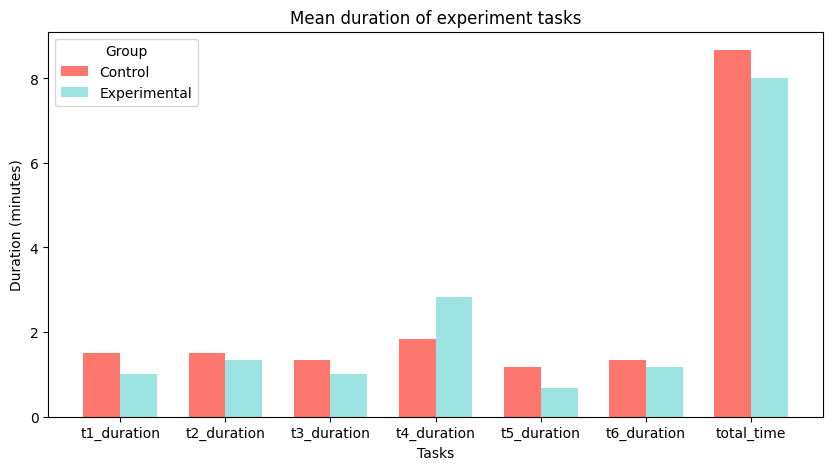

In [87]:
indices = np.arange(len(df_meansPlantUml))

bar_width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(indices, df_meansPlantUml['Mean Duration'], bar_width, color=color_plantuml, alpha=0.85, label='Control')
plt.bar(indices + bar_width, df_meansVisual['Mean Duration'], bar_width, color=color_visual, alpha=0.85, label='Experimental')

plt.title('Mean duration of experiment tasks')
plt.xlabel('Tasks')
plt.ylabel('Duration (minutes)')
plt.xticks(indices + bar_width / 2, df_meansPlantUml.index)
plt.legend(loc='upper left', title='Group')

plt.show()

In [88]:
t1CorrectCol = []
t2CorrectCol = []
t3CorrectCol = []

for idx in plantumlTasks.index:
    t1CorrectCol.append(plantumlTasks['t1'][idx] == 4)
    t2CorrectCol.append(plantumlTasks['t2'][idx] == 5)
    t3CorrectCol.append(plantumlTasks['t3'][idx] == 2)

# Add new columns to the plantumlTasks dataframe
plantumlTasks['t1_correct'] = t1CorrectCol
plantumlTasks['t2_correct'] = t2CorrectCol
plantumlTasks['t3_correct'] = t3CorrectCol

# Add columns regarding task4, task5 and task6 (as seen in the files on the PRs created)
plantumlTasks['t4_correct'] = [True, True, True, True, True, True]
plantumlTasks['t5_correct'] = [True, True, True, True, True, True]
plantumlTasks['t6_correct'] = [True, True, True, True, True, True]

# Remove old columns from the plantumlTasks dataframe
plantumlTasks.drop(['t1', 't2', 't3'], axis=1, inplace=True)

plantumlTasks

,t1_duration,t2_duration,t3_duration,t4_duration,t5_duration,t6_duration,total_time,t1_correct,t2_correct,t3_correct,t4_correct,t5_correct,t6_correct
id,,,,,,,,,,,,,
SB1,2.0,2.0,1.0,3.0,1.0,1.0,10.0,False,True,True,True,True,True
SB2,2.0,1.0,3.0,1.0,2.0,3.0,12.0,False,True,True,True,True,True
SB3,2.0,2.0,1.0,2.0,1.0,1.0,9.0,False,True,True,True,True,True
SB4,1.0,1.0,1.0,0.0,1.0,1.0,5.0,True,True,True,True,True,True
SB5,1.0,2.0,0.0,3.0,1.0,1.0,8.0,False,True,True,True,True,True
SB6,1.0,1.0,2.0,2.0,1.0,1.0,8.0,True,True,True,True,True,True


In [89]:
t1CorrectCol = []
t2CorrectCol = []
t3CorrectCol = []

for idx in visualTasks.index:
    t1CorrectCol.append(visualTasks['t1'][idx] == 4)
    t2CorrectCol.append(visualTasks['t2'][idx] == 5)
    t3CorrectCol.append(visualTasks['t3'][idx] == 2)

# Add new columns to the visualTasks dataframe
visualTasks['t1_correct'] = t1CorrectCol
visualTasks['t2_correct'] = t2CorrectCol
visualTasks['t3_correct'] = t3CorrectCol

# Add columns regarding task4, task5 and task6 (as seen in the files on the PRs created)
visualTasks['t4_correct'] = [True, True, True, True, True, True]
visualTasks['t5_correct'] = [True, True, True, True, True, True]
visualTasks['t6_correct'] = [True, True, True, True, True, True]

# Remove old columns from the visualTasks dataframe
visualTasks.drop(['t1', 't2', 't3'], axis=1, inplace=True)

visualTasks

,t1_duration,t2_duration,t3_duration,t4_duration,t5_duration,t6_duration,total_time,t1_correct,t2_correct,t3_correct,t4_correct,t5_correct,t6_correct
id,,,,,,,,,,,,,
WM1,2.0,2.0,1.0,5.0,1.0,1.0,12.0,True,True,True,True,True,True
WM2,1.0,1.0,1.0,2.0,0.0,1.0,6.0,True,True,True,True,True,True
WM3,1.0,2.0,1.0,1.0,1.0,1.0,7.0,True,True,True,True,True,True
WM4,1.0,1.0,1.0,2.0,1.0,1.0,7.0,True,True,True,True,True,True
WM5,0.0,1.0,1.0,4.0,0.0,1.0,7.0,True,True,True,True,True,True
WM6,1.0,1.0,1.0,3.0,1.0,2.0,9.0,True,True,True,True,True,True


In [90]:
taskDurationParams = ['t1_duration', 't2_duration', 't3_duration', 't4_duration', 't5_duration', 't6_duration', 'total_time']

plantumlTasksToPlot = plantumlTasks[taskDurationParams].copy()
plantumlTasksToPlot["group"] = "Control"

visualTasksToPlot = visualTasks[taskDurationParams].copy()
visualTasksToPlot["group"] = "Experimental"

tasksToPlot = pd.concat([plantumlTasksToPlot, visualTasksToPlot])
tasksToPlot

,t1_duration,t2_duration,t3_duration,t4_duration,t5_duration,t6_duration,total_time,group
id,,,,,,,,
SB1,2.0,2.0,1.0,3.0,1.0,1.0,10.0,Control
SB2,2.0,1.0,3.0,1.0,2.0,3.0,12.0,Control
SB3,2.0,2.0,1.0,2.0,1.0,1.0,9.0,Control
SB4,1.0,1.0,1.0,0.0,1.0,1.0,5.0,Control
SB5,1.0,2.0,0.0,3.0,1.0,1.0,8.0,Control
SB6,1.0,1.0,2.0,2.0,1.0,1.0,8.0,Control
WM1,2.0,2.0,1.0,5.0,1.0,1.0,12.0,Experimental
WM2,1.0,1.0,1.0,2.0,0.0,1.0,6.0,Experimental
WM3,1.0,2.0,1.0,1.0,1.0,1.0,7.0,Experimental


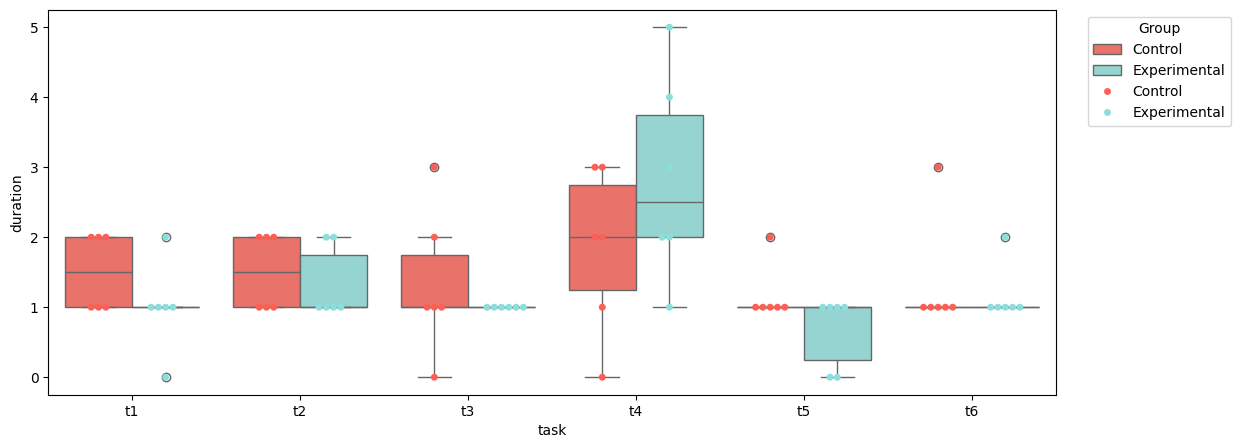

In [91]:
df = pd.DataFrame(columns=['task', 'duration', 'group'], index=[x for x in range(1, 36)])

count = 1
for idx in tasksToPlot.index:
    for col in taskDurationParams:
        if "total" in col:
            continue
        
        df.loc[count] = pd.Series({'task': col[:2], 'duration': tasksToPlot[col][idx], 'group': tasksToPlot['group'][idx]})
        count += 1
    
sns.set_palette(sns.color_palette(groupPallete))

plt.figure(figsize=(13, 5))
sns.boxplot(data=df, x="task", y="duration", hue="group")
task_times_plot = sns.swarmplot(data=df, x="task", y="duration", hue="group", dodge=True)
sns.move_legend(task_times_plot, "upper left", bbox_to_anchor=(1.025, 1.0), title="Group")

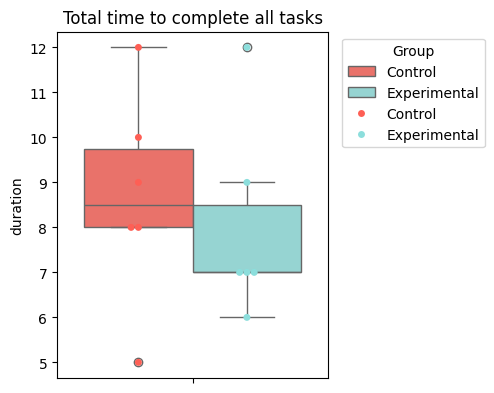

In [92]:
df = pd.DataFrame(columns=['task', 'duration', 'group'], index=[x for x in range(1, 36)])

count = 1
for idx in tasksToPlot.index:
    for col in taskDurationParams:
        if "total" not in col:
            continue
        df.loc[count] = pd.Series({'task': col, 'duration': tasksToPlot[col][idx], 'group': tasksToPlot['group'][idx]})
        count += 1
    
sns.set_palette(sns.color_palette(groupPallete))

plt.figure(figsize=(3.5, 4.5))
sns.boxplot(data=df, y="duration", hue="group").set_title('Total time to complete all tasks')
total_time_plot = sns.swarmplot(data=df, y="duration", hue="group", dodge=True)
sns.move_legend(total_time_plot, "upper left", bbox_to_anchor=(1.025, 1.0), title="Group")

In [93]:
totalAnswers = 6 * 6

plantumlCorrectAnswers = {
    'task1': sum(1 for x in plantumlTasks['t1_correct'] if x),
    'task2': sum(1 for x in plantumlTasks['t2_correct'] if x),
    'task3': sum(1 for x in plantumlTasks['t3_correct'] if x),
    'task4': sum(1 for x in plantumlTasks['t4_correct'] if x),
    'task5': sum(1 for x in plantumlTasks['t5_correct'] if x),
    'task6': sum(1 for x in plantumlTasks['t6_correct'] if x)
}

visualCorrectAnswers = {
    'task1': sum(1 for x in visualTasks['t1_correct'] if x),
    'task2': sum(1 for x in visualTasks['t2_correct'] if x),
    'task3': sum(1 for x in visualTasks['t3_correct'] if x),
    'task4': sum(1 for x in visualTasks['t4_correct'] if x),
    'task5': sum(1 for x in visualTasks['t5_correct'] if x),
    'task6': sum(1 for x in visualTasks['t6_correct'] if x)
}

print("plantuml correct answers: ", plantumlCorrectAnswers)
print("visual correct answers: ", visualCorrectAnswers)

# basta só referir no texto - não preciso de gráfico aqui

plantuml correct answers:  {'task1': 2, 'task2': 6, 'task3': 6, 'task4': 6, 'task5': 6, 'task6': 6}
visual correct answers:  {'task1': 6, 'task2': 6, 'task3': 6, 'task4': 6, 'task5': 6, 'task6': 6}


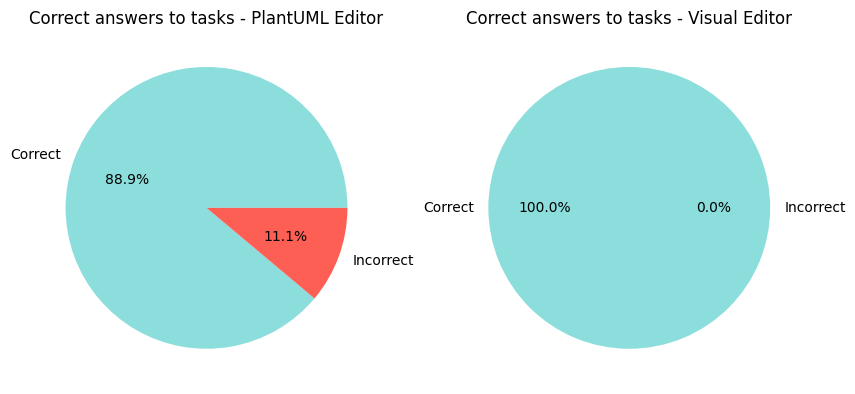

In [94]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,10)) #ax1,ax2 refer to your two pies

correctPlantuml = 0
for k in plantumlCorrectAnswers:
    correctPlantuml += plantumlCorrectAnswers[k]

correctVisual = 0
for k in visualCorrectAnswers:
    correctVisual += visualCorrectAnswers[k]

labelsPieCharts = ['Correct','Incorrect']
colorsPieCharts = [color_visual, color_plantuml]

values = [correctPlantuml, totalAnswers - correctPlantuml]
ax1.pie(values, labels = labelsPieCharts, colors = colorsPieCharts, autopct = '%1.1f%%')
ax1.set_title('Correct answers to tasks - PlantUML Editor')

values = [correctVisual, totalAnswers - correctVisual]
ax2.pie(values,labels = labelsPieCharts, colors = colorsPieCharts, autopct = '%1.1f%%')
ax2.set_title('Correct answers to tasks - Visual Editor')

plt.show()

## Analysis on Technology Acceptance Model (TAM) Answers

I'll transform the answers of the participants into the Likert scale (from 1-7) and then I'll plot some graphs and calculate the final TAM Score.

In [95]:
tamLikert = {'Strongly Disagree': 1, 'Quite Disagree': 2, 'Slightly Disagree': 3, 'Neither': 4, 'Slightly Agree': 5, 'Quite Agree': 6, 'Strongly Agree': 7}

tamLikertScale = [x for x in tamLikert.keys()]
colorsTam = ['#ffffff00', "#d83939", "#df8383", "#efc1c1", "#fcf39a", "#bde1c2", "#7bc37b", "#50a158"]

c:\Users\Matilde Barra\AppData\Local\Programs\Python\Python312\Lib\site-packages\plot_likert\plot_likert.py:257: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.applymap(validate)


<Axes: title={'center': 'Control Group TAM Results'}, xlabel='Number of Responses'>

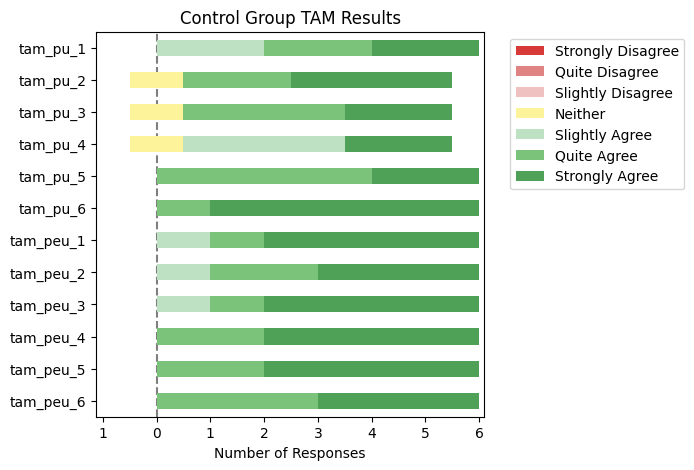

In [96]:
likertPlantUmlTam = plantumlTam[["tam_pu_1", "tam_pu_2", "tam_pu_3", "tam_pu_4", "tam_pu_5", "tam_pu_6", "tam_peu_1", "tam_peu_2", "tam_peu_3", "tam_peu_4", "tam_peu_5", "tam_peu_6" ]]

pl.plot_likert(likertPlantUmlTam, colors=colorsTam, plot_scale=tamLikertScale, title="Control Group TAM Results", figsize=(5, 5))

c:\Users\Matilde Barra\AppData\Local\Programs\Python\Python312\Lib\site-packages\plot_likert\plot_likert.py:257: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.applymap(validate)


<Axes: title={'center': 'Experimental Group TAM Results'}, xlabel='Number of Responses'>

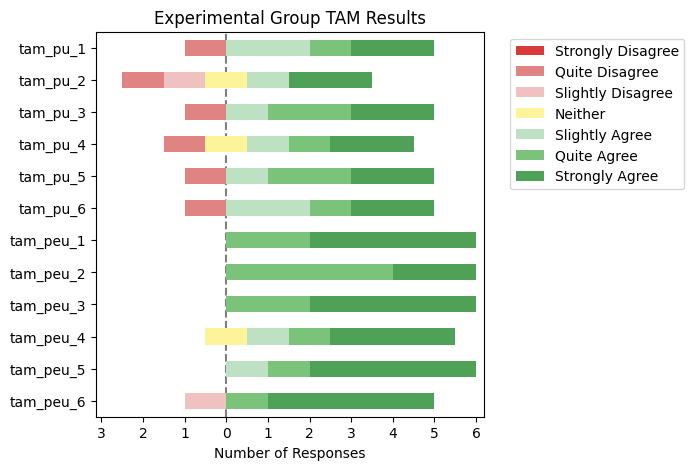

In [97]:
likertVisualTam = visualTam[["tam_pu_1", "tam_pu_2", "tam_pu_3", "tam_pu_4", "tam_pu_5", "tam_pu_6", "tam_peu_1", "tam_peu_2", "tam_peu_3", "tam_peu_4", "tam_peu_5", "tam_peu_6" ]]

pl.plot_likert(likertVisualTam, colors=colorsTam, plot_scale=tamLikertScale, title="Experimental Group TAM Results", figsize=(5, 5))

c:\Users\Matilde Barra\AppData\Local\Programs\Python\Python312\Lib\site-packages\plot_likert\plot_likert.py:257: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.applymap(validate)
c:\Users\Matilde Barra\AppData\Local\Programs\Python\Python312\Lib\site-packages\plot_likert\plot_likert.py:257: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.applymap(validate)


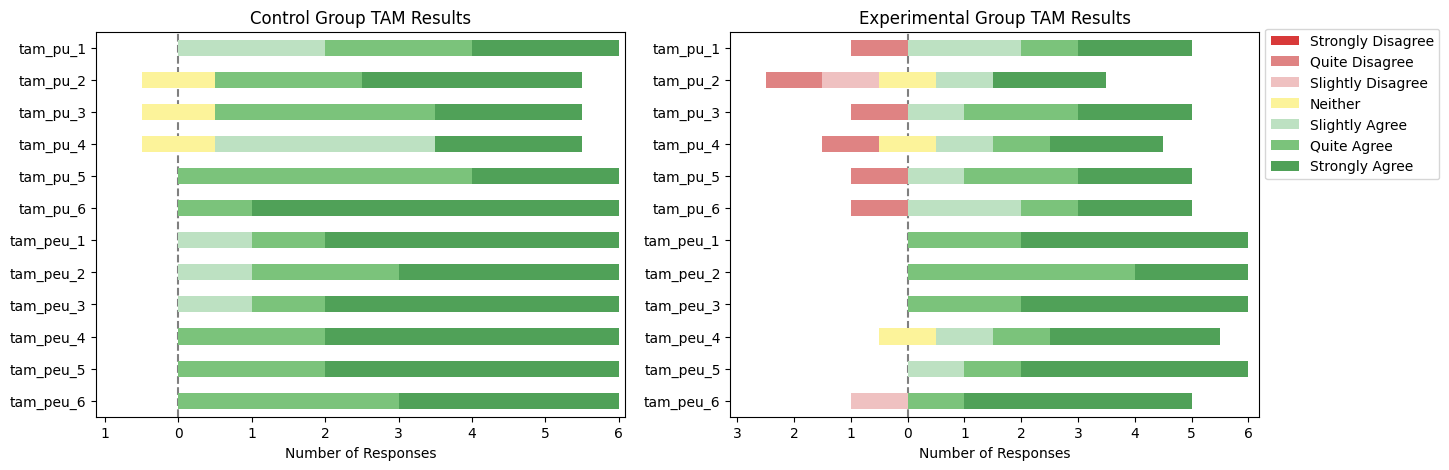

In [98]:
fig, (cG,eG) = plt.subplots(1, 2, figsize=(15,5))

pl.plot_likert(likertPlantUmlTam, colors=colorsTam, plot_scale=tamLikertScale, title="Control Group TAM Results", ax=cG, legend=False)

pl.plot_likert(likertVisualTam, colors=colorsTam, plot_scale=tamLikertScale, title="Experimental Group TAM Results", ax=eG, legend=False)

# display a single legend for the whole figure
handles, labels = eG.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.025, 0.9))
plt.show()

In [99]:
for col in plantumlTam.columns:
    if "just" not in col:
        newCol = []

        for idx in plantumlTam.index:
            value = plantumlTam[col][idx]
            newCol.append(int(tamLikert[value]))
            
        plantumlTam.drop(col, axis=1, inplace=True)
        plantumlTam[col] = newCol

plantumlTam

,tam_pu_just,tam_peu_just,tam_pu_1,tam_pu_2,tam_pu_3,tam_pu_4,tam_pu_5,tam_pu_6,tam_peu_1,tam_peu_2,tam_peu_3,tam_peu_4,tam_peu_5,tam_peu_6
id,,,,,,,,,,,,,,
SB1,"In many of the options I selected ""Neither"", b...","Overall, it is very simple and straightforward...",5,4,4,4,6,6,7,7,7,6,7,6
SB2,It is easy to use and simpler to work with tha...,It is easy to understand what types of boxes a...,6,7,7,7,7,7,6,7,7,7,7,7
SB3,The tool allows to quickly create a uml diagra...,"It is easy to edit and to add components , the...",5,6,6,5,6,7,7,5,6,6,6,6
SB4,Having a tool that automates the process of do...,Given that the underline language technology c...,7,7,7,7,7,7,5,6,5,7,7,6
SB5,The tool can improve the worker's performance ...,The interface of the tool is clean and gives g...,6,7,6,5,6,7,7,7,7,7,6,7
SB6,For the job of creating and maintaining archit...,The tool is very intuitive and simple to use. ...,7,6,6,5,6,7,7,6,7,7,7,7


In [100]:
for col in visualTam.columns:
    if "just" not in col:
        newCol = []

        for idx in visualTam.index:
            value = visualTam[col][idx]
            newCol.append(int(tamLikert[value]))
            
        visualTam.drop(col, axis=1, inplace=True)
        visualTam[col] = newCol

visualTam

,tam_pu_just,tam_peu_just,tam_pu_1,tam_pu_2,tam_pu_3,tam_pu_4,tam_pu_5,tam_pu_6,tam_peu_1,tam_peu_2,tam_peu_3,tam_peu_4,tam_peu_5,tam_peu_6
id,,,,,,,,,,,,,,
WM1,The tool allow us to quickly set up something ...,Pretty intuitive but missing ctrl c/ctrl v. Al...,7,7,7,7,7,7,6,6,7,7,7,7
WM2,\nI'm used to using tools like LucidChart and ...,I was able to do all the tasks from this exper...,7,7,7,7,7,7,7,7,7,7,7,7
WM3,I don't use docker nor diagrams in my job,"it's just an overall easy to use tool, it coul...",2,2,2,2,2,2,6,7,7,5,7,6
WM4,I think the tool can be very useful to properl...,I got a brief explanation before starting this...,6,4,6,6,6,6,7,6,7,7,7,7
WM5,The tool would be good to rapidly draft the ar...,The tool is simple. That allows for a user to ...,5,5,5,5,6,5,7,6,6,4,5,3
WM6,The tool is useful in the sense that it avoids...,The way to manipulate the elements is simple a...,5,3,6,4,5,5,7,6,6,6,6,7


In [101]:
# test the difference between them
valuesLess = []
valuesTwoSided = []
valuesGreater = []
columns = []
lowerList = []
significantList = []

for col in plantumlTam.columns:
    if ("just" in col):
        continue

    columns.append(col)
    
    print(f"Testing {col} ----")
    lessRes = testStatisticalDifference(visualTam[col], plantumlTam[col], alt="less")
    twoSidedRes = testStatisticalDifference(visualTam[col], plantumlTam[col])
    greaterRes = testStatisticalDifference(visualTam[col], plantumlTam[col], alt="greater")

    valuesLess.append(lessRes)
    valuesTwoSided.append(twoSidedRes)
    valuesGreater.append(greaterRes)

    lower =""
    if (lessRes < twoSidedRes and lessRes < greaterRes):
        lower = "Less"
    elif (twoSidedRes < lessRes and twoSidedRes < greaterRes):
        lower = "Two-sided"
    elif (greaterRes < lessRes and greaterRes < twoSidedRes):
        lower = "Greater"

    lowerList.append(lower)

    significant = False

    if (lessRes < 0.05 or twoSidedRes < 0.05 or greaterRes < 0.05):
        significant = True

    significantList.append(significant)

# Create a new dataframe with the p-values
pValues = pd.DataFrame(data=[valuesLess, valuesTwoSided, valuesGreater, lowerList, significantList], index=["Less", "Two-sided", "Greater", "Visual compared to PlantUML?", "Significant Difference?" ], columns=columns)
pValues


Testing tam_pu_1 ----
Testing tam_pu_2 ----
Testing tam_pu_3 ----
Testing tam_pu_4 ----
Testing tam_pu_5 ----
Testing tam_pu_6 ----
Testing tam_peu_1 ----
Testing tam_peu_2 ----
Testing tam_peu_3 ----
Testing tam_peu_4 ----
Testing tam_peu_5 ----
Testing tam_peu_6 ----


C:\Users\Matilde Barra\AppData\Local\Temp\ipykernel_15380\2276942039.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (g1QuestionAnswers[idx] != g2QuestionAnswers[idx]):


,tam_pu_1,tam_pu_2,tam_pu_3,tam_pu_4,tam_pu_5,tam_pu_6,tam_peu_1,tam_peu_2,tam_peu_3,tam_peu_4,tam_peu_5,tam_peu_6
Less,0.223769,0.121673,0.292285,0.364697,0.270754,0.036452,0.613585,0.464506,0.613585,0.208796,0.461671,0.6425
Two-sided,0.447538,0.243345,0.584569,0.729393,0.541508,0.072905,0.923342,0.929013,0.923342,0.417593,0.923342,0.855132
Greater,0.776231,0.908789,0.707715,0.635303,0.783765,0.975739,0.461671,0.605366,0.461671,0.839093,0.613585,0.427566
Visual compared to PlantUML?,Less,Less,Less,Less,Less,Less,Greater,Less,Greater,Less,Less,Greater
Significant Difference?,False,False,False,False,False,True,False,False,False,False,False,False


In [102]:
tamQuestionColumns = [col for col in plantumlTam.columns if "just" not in col]

In [103]:
meansPlantUmlTam = []
stDevsPlantUmlTam = []

for col in tamQuestionColumns:
    meansPlantUmlTam.append(round(plantumlTam[col].mean(), 2))
    stDevsPlantUmlTam.append(round(plantumlTam[col].std(), 2))

statisticDataTamPlantUML = {
    "Question": list(tamQuestionColumns),
    "Mean": meansPlantUmlTam,
    "StDev": stDevsPlantUmlTam
}

df_meansPlantUmlTam = pd.DataFrame(statisticDataTamPlantUML, columns=['Question', 'Mean', 'StDev'])
df_meansPlantUmlTam.set_index('Question', inplace=True)
df_meansPlantUmlTam

,Mean,StDev
Question,,
tam_pu_1,6.00,0.89
tam_pu_2,6.17,1.17
tam_pu_3,6.00,1.10
tam_pu_4,5.50,1.22
tam_pu_5,6.33,0.52
tam_pu_6,6.83,0.41
tam_peu_1,6.50,0.84
tam_peu_2,6.33,0.82
tam_peu_3,6.50,0.84


In [104]:
meansVisualTam = []
stDevsVisualTam = []

for col in tamQuestionColumns:
    meansVisualTam.append(round(visualTam[col].mean(), 2))
    stDevsVisualTam.append(round(visualTam[col].std(), 2))

statisticDataTamVisual = {
    "Question": list(tamQuestionColumns),
    "Mean": meansVisualTam,
    "StDev": stDevsVisualTam
}

df_meansVisualTam = pd.DataFrame(statisticDataTamVisual, columns=['Question', 'Mean', 'StDev'])
df_meansVisualTam.set_index('Question', inplace=True)
df_meansVisualTam

,Mean,StDev
Question,,
tam_pu_1,5.33,1.86
tam_pu_2,4.67,2.07
tam_pu_3,5.50,1.87
tam_pu_4,5.17,1.94
tam_pu_5,5.50,1.87
tam_pu_6,5.33,1.86
tam_peu_1,6.67,0.52
tam_peu_2,6.33,0.52
tam_peu_3,6.67,0.52


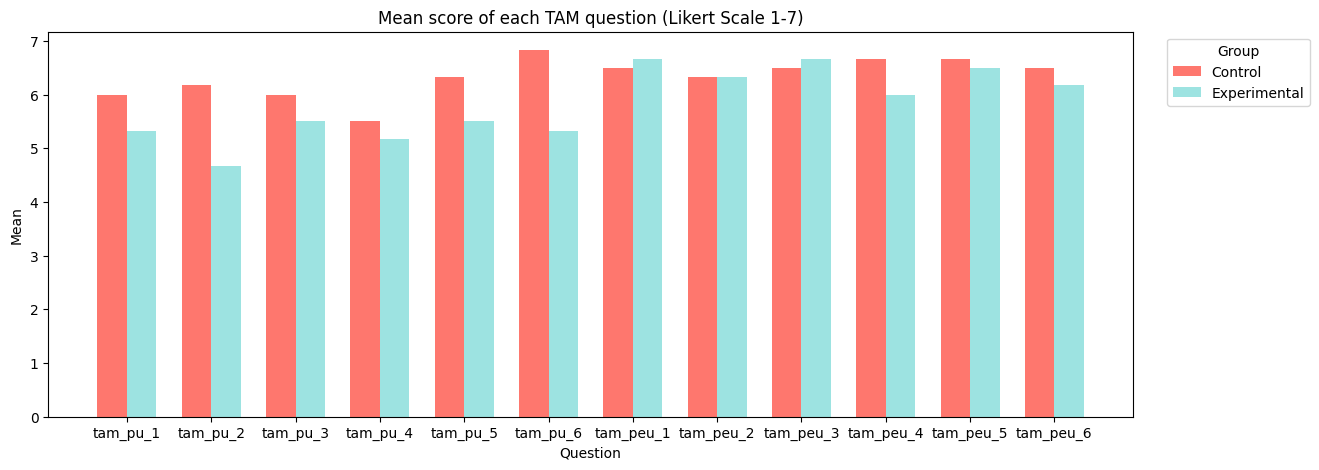

In [105]:
indices = np.arange(len(df_meansPlantUmlTam))

plt.figure(figsize=(14, 5))
plt.bar(indices, df_meansPlantUmlTam['Mean'], bar_width, color=color_plantuml, alpha=0.85, label='Control')
plt.bar(indices + bar_width, df_meansVisualTam['Mean'], bar_width, color=color_visual, alpha=0.85, label='Experimental')

plt.title('Mean score of each TAM question (Likert Scale 1-7)')
plt.xlabel('Question')
plt.ylabel('Mean')
plt.xticks(indices + bar_width / 2, df_meansPlantUmlTam.index)
plt.legend(bbox_to_anchor=(1.025, 1.0), loc='upper left', title='Group')

In [106]:
tam_scores_plantUml = []

for idx in plantumlTam.index:
    puValue = (plantumlTam.loc[idx, 'tam_pu_1':'tam_pu_6'].mean() - 1) * (100/6)
    peuValue = (plantumlTam.loc[idx, 'tam_peu_1':'tam_peu_6'].mean() - 1) * (100/6)

    tamValue = round((puValue + peuValue) / 2 , 2)
    tam_scores_plantUml.append(tamValue)

print("Participants TAM Scores (PlantUML):", tam_scores_plantUml)

plantumlTamScore = round(np.average(tam_scores_plantUml), 2)
print("PlantUML TAM Score:", plantumlTamScore)

Participants TAM Scores (PlantUML): [79.17, 97.22, 81.94, 91.67, 91.67, 91.67]
PlantUML TAM Score: 88.89


In [107]:
tam_scores_visual = []

for idx in visualTam.index:
    puValue = (visualTam.loc[idx, 'tam_pu_1':'tam_pu_6'].mean() - 1) * (100/6)
    peuValue = (visualTam.loc[idx, 'tam_peu_1':'tam_peu_6'].mean() - 1) * (100/6)

    tamValue = round((puValue + peuValue) / 2 , 2)
    tam_scores_visual.append(tamValue)

print("Participants TAM Scores (Visual):", tam_scores_visual)

visualTamScore = round(np.average(tam_scores_visual), 2)
print("Visual TAM Score:", visualTamScore)

Participants TAM Scores (Visual): [97.22, 100.0, 52.78, 87.5, 69.44, 75.0]
Visual TAM Score: 80.32


In [108]:
plantumlTamJust = plantumlTam[['tam_pu_just', 'tam_peu_just']]
visualTamJust = visualTam[['tam_pu_just', 'tam_peu_just']]

In [109]:
for idx in plantumlTamJust.index:
    print(idx, "\n    Perceived usefulness:", plantumlTamJust['tam_pu_just'][idx], "\n    Perceived ease-of-use:", plantumlTamJust['tam_peu_just'][idx])

print("--------------------------------")

for idx in visualTamJust.index:
    print(idx, "\n    Perceived usefulness:", visualTamJust['tam_pu_just'][idx], "\n    Perceived ease-of-use:", visualTamJust['tam_peu_just'][idx])

SB1 
    Perceived usefulness: In many of the options I selected "Neither", because although I find this tool very useful, it seems to be restricted to some specific use cases. Thus, I cannot say it would drastically increase my productivity. Despite that, it appears to facilitate the creation of diagrams which can indeed make some parts of my job easier. 
    Perceived ease-of-use: Overall, it is very simple and straightforward to use.
SB2 
    Perceived usefulness: It is easy to use and simpler to work with than other more known drag and drop tools that quickly become visually disorganized. The drop down menus make it so that even someone like me who as never used the language can quickly understand how things can be added by exploring the available options without visiting the documentation. I feel like it would be very useful to make quick changes to an architecture diagram even after a long time without visiting a project. 
    Perceived ease-of-use: It is easy to understand what 

## Analysis on System Usability Score (SUS) Answers

I'll transform the answers of the participants into the Likert scale (from 1-5) and then I'll plot some graphs and calculate the final SUS Score.

In [110]:
susLikert = {'Strongly Disagree': 1, 'Disagree': 2, 'Neither': 3, 'Agree': 4, 'Strongly Agree': 5}

susLikertScale = [x for x in susLikert.keys()]
colorsSus = ['#ffffff00', "#d83939", "#df8383", "#fcf39a", "#7bc37b", "#50a158"]

c:\Users\Matilde Barra\AppData\Local\Programs\Python\Python312\Lib\site-packages\plot_likert\plot_likert.py:257: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.applymap(validate)


<Axes: title={'center': 'Control Group SUS Results'}, xlabel='Number of Responses'>

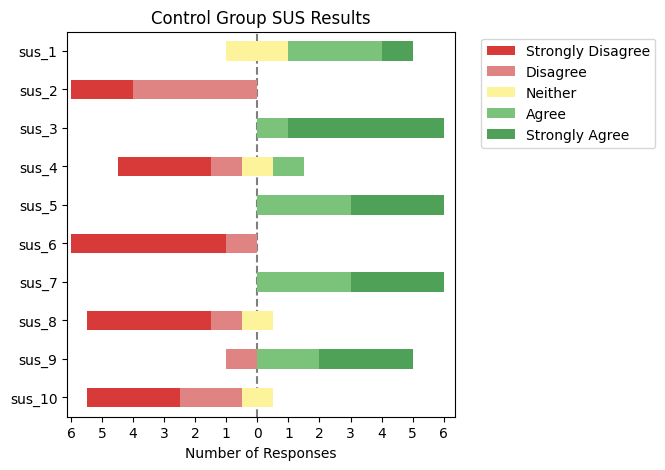

In [111]:
likertPlantUmlSus = plantumlSus[["sus_1", "sus_2", "sus_3", "sus_4", "sus_5", "sus_6", "sus_7", "sus_8", "sus_9", "sus_10"]]
pl.plot_likert(likertPlantUmlSus, colors=colorsSus, plot_scale=susLikertScale, title="Control Group SUS Results", figsize=(5, 5))

c:\Users\Matilde Barra\AppData\Local\Programs\Python\Python312\Lib\site-packages\plot_likert\plot_likert.py:257: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.applymap(validate)


<Axes: title={'center': 'Experimental Group SUS Results'}, xlabel='Number of Responses'>

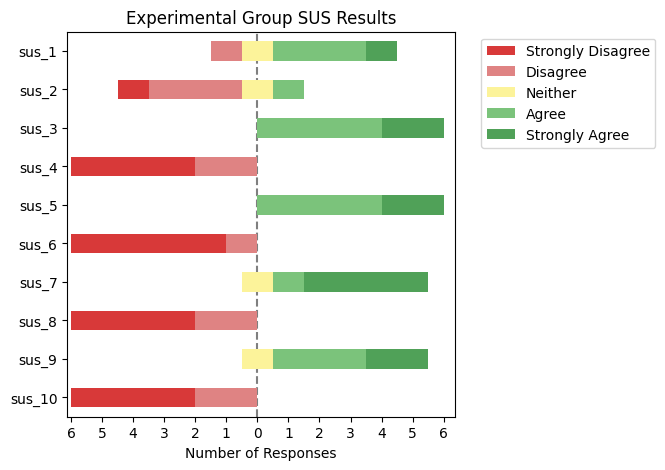

In [112]:
likertVisualSus = visualSus[["sus_1", "sus_2", "sus_3", "sus_4", "sus_5", "sus_6", "sus_7", "sus_8", "sus_9", "sus_10"]]

pl.plot_likert(likertVisualSus, colors=colorsSus, plot_scale=susLikertScale, title="Experimental Group SUS Results", figsize=(5, 5))

c:\Users\Matilde Barra\AppData\Local\Programs\Python\Python312\Lib\site-packages\plot_likert\plot_likert.py:257: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.applymap(validate)
c:\Users\Matilde Barra\AppData\Local\Programs\Python\Python312\Lib\site-packages\plot_likert\plot_likert.py:257: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.applymap(validate)


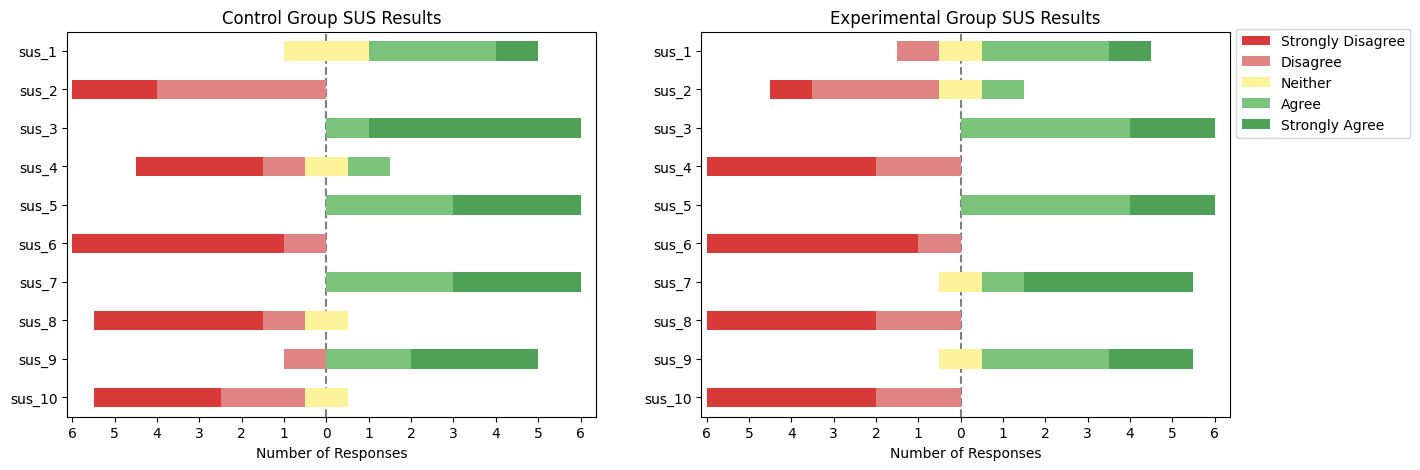

In [113]:
fig, (cG,eG) = plt.subplots(1, 2, figsize=(15,5))

pl.plot_likert(likertPlantUmlSus, colors=colorsSus, plot_scale=susLikertScale, title="Control Group SUS Results", ax=cG, legend=False)

pl.plot_likert(likertVisualSus, colors=colorsSus, plot_scale=susLikertScale, title="Experimental Group SUS Results", ax=eG, legend=False)

# display a single legend for the whole figure
handles, labels = eG.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.025, 0.9))
plt.show()

In [114]:
for col in plantumlSus.columns:
    if "just" not in col:
        newCol = []

        for idx in plantumlSus.index:
            value = plantumlSus[col][idx]
            newCol.append(int(susLikert[value]))
            
        plantumlSus.drop(col, axis=1, inplace=True)
        plantumlSus[col] = newCol

plantumlSus

,sus_just,sus_1,sus_2,sus_3,sus_4,sus_5,sus_6,sus_7,sus_8,sus_9,sus_10
id,,,,,,,,,,,
SB1,The usability is very good for a starting poin...,3,2,5,1,5,1,5,3,2,1
SB2,"I think anyone, regardless of having the speci...",5,1,5,1,5,1,5,1,5,1
SB3,I found it quite intuitive to add/edit/delete ...,4,2,4,3,4,2,4,2,5,3
SB4,"The tool was very usable, the hash IDs could b...",4,2,5,4,4,1,5,1,5,2
SB5,The system is easy to understand after a quick...,4,2,5,2,4,1,4,1,4,2
SB6,The system is very straight-forward and doesn'...,3,1,5,1,5,1,4,1,4,1


In [115]:
for col in visualSus.columns:
    if "just" not in col:
        newCol = []

        for idx in visualSus.index:
            value = visualSus[col][idx]
            newCol.append(int(susLikert[value]))
            
        visualSus.drop(col, axis=1, inplace=True)
        visualSus[col] = newCol

visualSus

,sus_just,sus_1,sus_2,sus_3,sus_4,sus_5,sus_6,sus_7,sus_8,sus_9,sus_10
id,,,,,,,,,,,
WM1,Easy to learn and discover stuff by myself,5,2,5,1,5,1,5,2,5,1
WM2,The tool is very easy to use and I believe tha...,4,1,5,1,5,1,5,1,4,1
WM3,I believe some people will have issues with th...,2,2,4,2,4,1,3,1,5,2
WM4,It's hard to justify - but I felt like control...,4,2,4,1,4,1,5,1,4,1
WM5,The system is simple and quite straight forwar...,3,4,4,1,4,2,5,1,4,1
WM6,The tool is quite intuitive and not overwhelmi...,4,3,4,2,4,1,4,2,3,2


In [116]:
# test the difference between them
valuesLess = []
valuesTwoSided = []
valuesGreater = []
columns = []
lowerList = []
significantList = []

for col in plantumlSus.columns:
    if ("just" in col):
        continue

    columns.append(col)
    # print(f"Testing {col} ----")
    lessRes = testStatisticalDifference(visualSus[col], plantumlSus[col], alt="less" )
    twoSidedRes = testStatisticalDifference(visualSus[col], plantumlSus[col])
    greaterRes = testStatisticalDifference(visualSus[col], plantumlSus[col], alt="greater")

    valuesLess.append(lessRes)
    valuesTwoSided.append(twoSidedRes)
    valuesGreater.append(greaterRes)

    lower =""
    if (lessRes < twoSidedRes and lessRes < greaterRes):
        lower = "Less"
    elif (twoSidedRes < lessRes and twoSidedRes < greaterRes):
        lower = "Two-sided"
    elif (greaterRes < lessRes and greaterRes < twoSidedRes):
        lower = "Greater"
    else:
        lower = "Equal"

    lowerList.append(lower)

    significant = False

    if (lessRes < 0.05 or twoSidedRes < 0.05 or greaterRes < 0.05):
        significant = True

    significantList.append(significant)

# Create a new dataframe with the p-values
pValues = pd.DataFrame(data=[valuesLess, valuesTwoSided, valuesGreater, lowerList, significantList], index=["Less", "Two-sided", "Greater", "Visual compared to PlantUML?", "Significant Difference?" ], columns=columns)
pValues

C:\Users\Matilde Barra\AppData\Local\Temp\ipykernel_15380\2276942039.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (g1QuestionAnswers[idx] != g2QuestionAnswers[idx]):


,sus_1,sus_2,sus_3,sus_4,sus_5,sus_6,sus_7,sus_8,sus_9,sus_10
Less,0.377984,0.911653,0.056098,0.208796,0.320187,0.549185,0.6425,0.461671,0.397823,0.261408
Two-sided,0.755967,0.24165,0.112196,0.417593,0.640374,1.0,0.855132,0.923342,0.795647,0.522817
Greater,0.622016,0.120825,0.962073,0.839093,0.743459,0.549185,0.427566,0.613585,0.666999,0.794343
Visual compared to PlantUML?,Less,Greater,Less,Less,Less,Equal,Greater,Less,Less,Less
Significant Difference?,False,False,False,False,False,False,False,False,False,False


In [117]:
susQuestionColumns = [col for col in plantumlSus.columns if "just" not in col]

In [118]:
meansPlantUmlSus = []
stDevsPlantUmlSus = []

for col in susQuestionColumns:
    meansPlantUmlSus.append(round(plantumlSus[col].mean(), 2))
    stDevsPlantUmlSus.append(round(plantumlSus[col].std(), 2))

statisticDataSusPlantUML = {
    "Question": list(susQuestionColumns),
    "Mean": meansPlantUmlSus,
    "StDev": stDevsPlantUmlSus
}

df_meansPlantUmlSus = pd.DataFrame(statisticDataSusPlantUML, columns=['Question', 'Mean', 'StDev'])
df_meansPlantUmlSus.set_index('Question', inplace=True)
df_meansPlantUmlSus

,Mean,StDev
Question,,
sus_1,3.83,0.75
sus_2,1.67,0.52
sus_3,4.83,0.41
sus_4,2.00,1.26
sus_5,4.50,0.55
sus_6,1.17,0.41
sus_7,4.50,0.55
sus_8,1.50,0.84
sus_9,4.17,1.17


In [119]:
meansVisualSus = []
stDevsVisualSus = []

for col in susQuestionColumns:
    meansVisualSus.append(round(visualSus[col].mean(), 2))
    stDevsVisualSus.append(round(visualSus[col].std(), 2))

statisticDataSusVisual = {
    "Question": list(susQuestionColumns),
    "Mean": meansVisualSus,
    "StDev": stDevsVisualSus
}

df_meansVisualSus = pd.DataFrame(statisticDataSusVisual, columns=['Question', 'Mean', 'StDev'])
df_meansVisualSus.set_index('Question', inplace=True)
df_meansVisualSus

,Mean,StDev
Question,,
sus_1,3.67,1.03
sus_2,2.33,1.03
sus_3,4.33,0.52
sus_4,1.33,0.52
sus_5,4.33,0.52
sus_6,1.17,0.41
sus_7,4.50,0.84
sus_8,1.33,0.52
sus_9,4.17,0.75


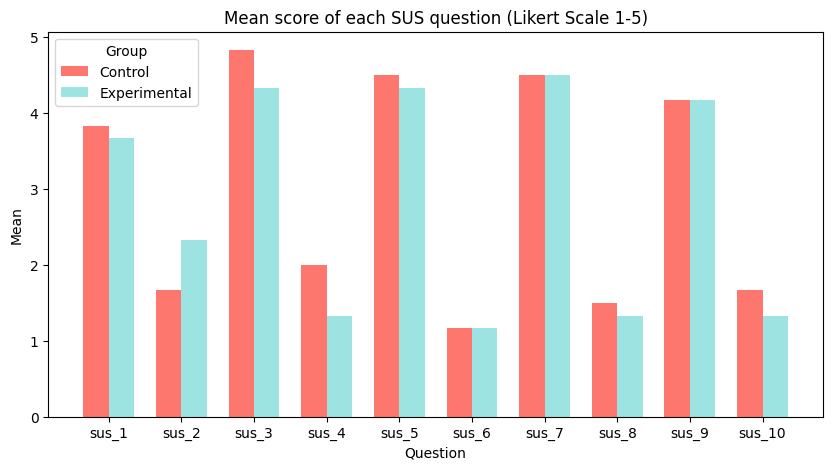

In [120]:
indices = np.arange(len(df_meansPlantUmlSus))

plt.figure(figsize=(10, 5))
plt.bar(indices, df_meansPlantUmlSus['Mean'], bar_width, color=color_plantuml, alpha=0.85, label='Control')
plt.bar(indices + bar_width, df_meansVisualSus['Mean'], bar_width, color=color_visual, alpha=0.85, label='Experimental')

plt.title('Mean score of each SUS question (Likert Scale 1-5)')
plt.xlabel('Question')
plt.ylabel('Mean')
plt.xticks(indices + bar_width / 2, df_meansPlantUmlSus.index)
plt.legend(loc='upper left', title='Group')

In [121]:
sus_scores_plantUml = []

for idx in plantumlSus.index:
    positive = 0
    negative = 0
    
    for col in plantumlSus.columns:
        if "just" in col:
            continue
        
        value = plantumlSus[col][idx]
        colNum = int(col.split('_')[1])

        if colNum % 2 == 0:
            negative += value
        else:
            positive += value
    
    positive -= 5
    negative = 25 - negative
    susValue = (positive + negative) * 2.5
    sus_scores_plantUml.append(susValue)

print("Participants SUS Scores (PlantUML):", sus_scores_plantUml)

plantumlSusScore = round(np.average(sus_scores_plantUml), 2)
print("PlantUML SUS Score:", plantumlSusScore)

Participants SUS Scores (PlantUML): [80.0, 100.0, 72.5, 82.5, 82.5, 90.0]
PlantUML SUS Score: 84.58


In [122]:
sus_scores_visual = []

for idx in visualSus.index:
    positive = 0
    negative = 0
    
    for col in visualSus.columns:
        if "just" in col:
            continue
          
        value = visualSus[col][idx]
        colNum = int(col.split('_')[1])

        if colNum % 2 == 0:
            negative += value
        else:
            positive += value

        if (colNum == 10):
            break
    
    positive -= 5
    negative = 25 - negative
    susValue = (positive + negative) * 2.5
    sus_scores_visual.append(susValue)

print("Participants SUS Scores (Visual):", sus_scores_visual)

visualSusScore = round(np.average(sus_scores_visual), 2)
print("Visual SUS Score:", visualSusScore)

Participants SUS Scores (Visual): [95.0, 95.0, 75.0, 87.5, 77.5, 72.5]
Visual SUS Score: 83.75


In [123]:
plantumlSusJust = plantumlSus[['sus_just']]
visualSusJust = visualSus[['sus_just']]

In [124]:
for idx in plantumlSusJust.index:
    print(idx, plantumlSusJust['sus_just'][idx])

print("--------------------------------")

for idx in visualSusJust.index:
    print(idx, visualSusJust['sus_just'][idx])

SB1 The usability is very good for a starting point, I would only add some minor improvements that would increase the engagement in the tool. For instances, associating each component with icons would increase the diagram edition speed, because one would not spend time searching in the dropdown menu for a given option. In addition to that, I would like to see more warnings (popups) just as a confirmation of what is being done to the diagram (e.g. Port added).
SB2 I think anyone, regardless of having the specific background in program architecture or UML could construct a model if given a bit of detail on what elements to add, given that the syntax seems straight forward and the dropdown menus make it easy to add. change or delete elements without much thought.
SB3 I found it quite intuitive to add/edit/delete components, the only downside is copying and pasting the ids
SB4 The tool was very usable, the hash IDs could be occluded in the frontend. As this product is directed to people wh

## Analysis on Comments and Questions about features

Analysing the comments received and plot graphs about the importance of certain features for this type of tools.

In [125]:
featureCols = ['undo_redo', 'move_elements', 'keyboard_keys', "uml_compliant"]

colsYesPlantuml = {}
for col in featureCols:
    colCount = 0
    for idx in plantumlFeatures.index:
        if(plantumlFeatures[col][idx] == "Yes"):
            colCount += 1
    
    colsYesPlantuml[col] = colCount

colsYesVisual = {}
for col in featureCols:
    colCount = 0
    for idx in visualFeatures.index:
        if(visualFeatures[col][idx] == "Yes"):
            colCount += 1

    colsYesVisual[col] = colCount

dfCountPlantUml = pd.DataFrame(list(colsYesPlantuml.items()), columns=['Feature', 'Votes for?'])
dfCountPlantUml['group'] = 'Control'

dfCountVisual = pd.DataFrame(list(colsYesVisual.items()), columns=['Feature', 'Votes for?'])
dfCountVisual['group'] = 'Experimental'

dfVotesPlot = pd.concat([dfCountPlantUml, dfCountVisual])
dfVotesPlot

,Feature,Votes for?,group
0,undo_redo,6,Control
1,move_elements,5,Control
2,keyboard_keys,3,Control
3,uml_compliant,6,Control
0,undo_redo,6,Experimental
1,move_elements,6,Experimental
2,keyboard_keys,5,Experimental
3,uml_compliant,5,Experimental


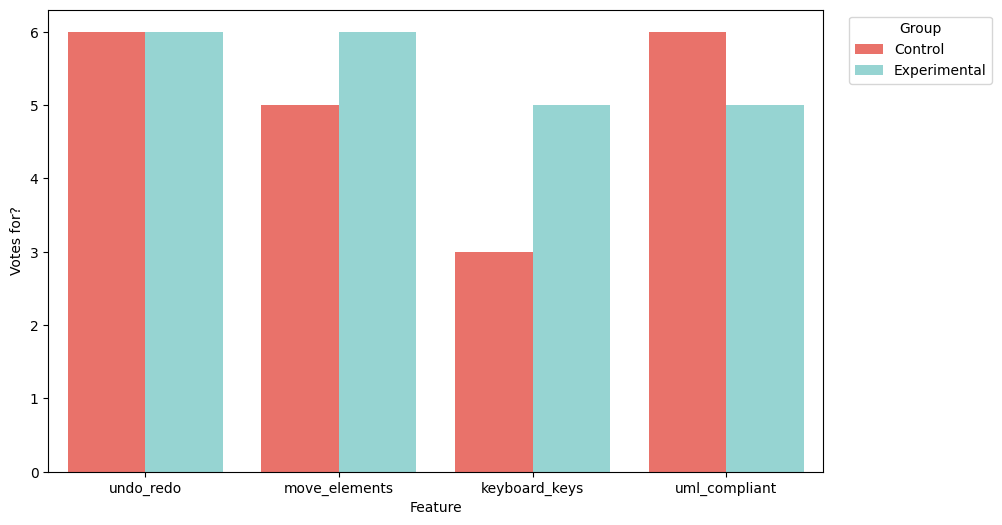

In [126]:
plt.figure(figsize=(10, 6))
votes_plot = sns.barplot(data=dfVotesPlot, x='Feature', y='Votes for?', hue='group', palette=groupPallete)
sns.move_legend(votes_plot, "upper left", bbox_to_anchor=(1.025, 1.0), title="Group")

In [127]:
valuesLess = []
valuesTwoSided = []
valuesGreater = []
columns = []
lowerList = []
significantList = []

for col in plantumlFeatures.columns:
    if "just" in col or "comments" in col:
        continue

    plantumlFeatAnswers = [1 if x == "Yes" else 0 for x in plantumlFeatures[col]]
    visualFeatAnswers = [1 if x == "Yes" else 0 for x in visualFeatures[col]]
    

    columns.append(col)
    # print(f"Testing {col} ----")
    lessRes = testStatisticalDifference(visualFeatAnswers, plantumlFeatAnswers, alt="less")
    twoSidedRes = testStatisticalDifference(visualFeatAnswers, plantumlFeatAnswers)
    greaterRes = testStatisticalDifference(visualFeatAnswers, plantumlFeatAnswers, alt="greater")

    valuesLess.append(lessRes)
    valuesTwoSided.append(twoSidedRes)
    valuesGreater.append(greaterRes)

    equalText = "No difference between groups"
    lower = "Equal"
    significant = False
    if not (lessRes == equalText or twoSidedRes == equalText or greaterRes == equalText):
        print(lessRes)

        if (lessRes < twoSidedRes and lessRes < greaterRes):
            lower = "Less"
        elif (twoSidedRes < lessRes and twoSidedRes < greaterRes):
            lower = "Two-sided"
        elif (greaterRes < lessRes and greaterRes < twoSidedRes):
            lower = "Greater"



        if (lessRes < 0.05 or twoSidedRes < 0.05 or greaterRes < 0.05):
            significant = True

    lowerList.append(lower)
    significantList.append(significant)

# Create a new dataframe with the p-values
pValues = pd.DataFrame(data=[valuesLess, valuesTwoSided, valuesGreater, lowerList, significantList], index=["Less", "Two-sided", "Greater", "Visual compared to PlantUML?", "Significant Difference?" ], columns=columns)
pValues

0.8783274954256188
0.8980148330240619
0.20232838096364308


c:\Users\Matilde Barra\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


,undo_redo,move_elements,keyboard_keys,uml_compliant
Less,No difference between groups,0.878327,0.898015,0.202328
Two-sided,No difference between groups,0.404657,0.282425,0.404657
Greater,No difference between groups,0.202328,0.141213,0.878327
Visual compared to PlantUML?,Equal,Greater,Greater,Less
Significant Difference?,False,False,False,False


In [128]:
plantumlFeatJust = plantumlFeatures[["undo_redo_just", "move_elements_just", "keyboard_keys_just", "uml_compliant_just"]]
plantumlComments = plantumlFeatures[["comments"]]

visualFeatJust = visualFeatures[["undo_redo_just", "move_elements_just", "keyboard_keys_just", "uml_compliant_just"]]
visualComments = visualFeatures[["comments"]]

In [129]:
for idx in plantumlFeatJust.index:
    print(idx, "\n    Undo/Redo:", plantumlFeatJust['undo_redo_just'][idx], "\n    Move Elements:", plantumlFeatJust['move_elements_just'][idx], "\n    Keyboard Keys:", plantumlFeatJust['keyboard_keys_just'][idx], "\n    UML compliant:", plantumlFeatJust['uml_compliant_just'][idx])

print("--------------------------------")

for idx in visualFeatJust.index:
    print(idx, "\n    Undo/Redo:", visualFeatJust['undo_redo_just'][idx], "\n    Move Elements:", visualFeatJust['move_elements_just'][idx], "\n    Keyboard Keys:", visualFeatJust['keyboard_keys_just'][idx], "\n    UML compliant:", visualFeatJust['uml_compliant_just'][idx])

SB1 
    Undo/Redo: It is very important to don't lose time trying to mimic that feature ourselves. 
    Move Elements: This tool reminds me of draw.io and I would enjoy seeing a similar experience to that tool in this one. I consider a lot more engaging moving and "feeling" the elements in first hand. 
    Keyboard Keys: I don't see people using the keyboard that much, it should support it anyway because of the accessibility 
    UML compliant: Although I am not sure, it seems that it follows all the UML standards.
SB2 
    Undo/Redo: Many times you delete or change things that you didn't mean to and need to roll back changes so it is useful to have some kind of CTRL-Z. 
    Move Elements: moving elements that may be related together if they were initially written in sections apart is useful for having them both in view if I am trying to make some decisions on what information should be in each one. 
    Keyboard Keys: As with every digital tool, the use of keyboard shortcuts makes fo

In [130]:
for idx in plantumlComments.index:
    print(idx, plantumlComments['comments'][idx])

print("--------------------------------")

for idx in visualComments.index:
    print(idx, visualComments['comments'][idx])

SB1 I would like to see this extended to other type of files, for example github actions, pipelines, etc. This would highly increase this tool use cases.
SB2 No
SB3 nan
SB4 The hash IDs could be occluded in the frontend. Give a tl;dr to explain the type of  connections. Private repositories. Specify the folder of docker-compose files. Is it possible to use more than one docker-compose file, is there folder recursion?
SB5 A feature that I think could be interesting is a way to see a list of the element's connections maybe in its dropdown menu options
SB6 It would be nice to be able to click on a property on the rendered diagram to focus that specific property on the left.
--------------------------------
WM1 Copy and past would be very helpful
WM2 Just for design purposes might be nice in the future to allow users to pick the colors of components and text? Also I believe the redo feature would be very useful.

Besides that I would like to congratulate the maker of the tool, it's awesome

## TODO

- Analisar respostas corretas e erradas (nas tasks) ✅
- Traduzir resposta WM6 para inglês ✅
- Gráficos:
    - Tempo decorrido por tarefa por grupo (médio?) ✅
    - Tasks completas de forma bem sucedida ✅
    - TAM answers ✅ + Scale ✅
    - SUS answers ✅ + Score ✅
    - Opiniões sobre features (yes/no) por grupo ✅
    - Dar print de todos os comments ✅
    - Analisar os comments obtidos (ler e retirar as principais conclusões)